## Fine Tune a PreTrain a BERT model for Binary classification
Before this, the data must be processed, tokenized and prepared. Next, we need a pretrained bert model.
1. `data_processing` notebook loads raw data and prepares training,validation and test dataset
2. `data_tokenizer`notebook tokenizes the data using LiPCoT model
3. `data_prepare` notebook prepares datasets for BERT models
4. `pretrain_bert` notebook conducts pretraining of BERT model

Here, we will use training and validation dataset for fine-tuning. Then test set is used for evaluation
### 1. Import libraries

In [1]:
import os
import joblib
from modules.bert_module import *
from modules.path_module import *
from transformers import BertForMaskedLM
from torch import cuda
from tqdm import tqdm
import torch.optim as optim
from torch.utils.data import DataLoader

### 2. Load datasets
We are going to use the validation set for training the fine-tune model. The training set for the pre-trained model will be used with labels as a validation.

In [2]:
train_dataset=joblib.load( os.path.join(bert_datapath,"val_data.joblib"))
val_dataset=joblib.load( os.path.join(bert_datapath,"train_data.joblib"))
test_dataset=joblib.load(os.path.join(bert_datapath,"test_data.joblib"))

### 3. Create Fine-tune classification model

In [3]:
model = BertForMaskedLM.from_pretrained(bert_modelpath)
print('PreTrained Model loaded')
# use GPU
device='cuda' if cuda.is_available() else 'cpu'
print("Running on: "+device)
cuda.empty_cache()

# Instantiate the classification model
num_classes = 2  # Number of classes in classification task
classification_model = BertForSequenceClassification(model, num_classes,device)
classification_model.to(device)  # Move model to the device (e.g., GPU if available)
print('FineTune Model created')

PreTrained Model loaded
Running on: cuda
FineTune Model created


### 4. Configure Training 

In [4]:
num_epochs = 64 #128
training_batch_size=4
learning_rate=1.888861270702437e-05
# Define optimizer and loss function
optimizer = optim.Adam(classification_model.parameters(), lr=learning_rate)
criterion = nn.BCELoss()#nn.CrossEntropyLoss()
bert_finetune_modelfullpath=os.path.join(bert_finetune_modelpath,'finetune_bert.pt')

random_seed=42
patience=80
training_arg={
    'modelfullpath': bert_finetune_modelfullpath,
    'criterion': criterion,
    'optimizer': optimizer,
    'epochs': num_epochs,
    'patience': patience,
    'seed': random_seed
}

### 5. Create DataLoaders

In [5]:
train_loader = DataLoader(train_dataset, batch_size=training_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

### 6. Train and evaluate via validation set
We train using the training set and save the model that gives the best performance on the validation set

In [6]:
results= model_trainer(classification_model,train_loader,val_loader,training_arg,device)

Epoch 1/64: 100%|██████████| 35/35 [00:02<00:00, 17.29batch/s, Loss=0.592]


model state saved with validation accuracy: 72.9814


Epoch 2/64: 100%|██████████| 35/35 [00:01<00:00, 21.51batch/s, Loss=0.822]


model state saved with validation accuracy: 73.2919


Epoch 3/64: 100%|██████████| 35/35 [00:01<00:00, 19.52batch/s, Loss=0.383]


model state saved with validation accuracy: 74.8447


Epoch 4/64: 100%|██████████| 35/35 [00:01<00:00, 20.33batch/s, Loss=0.0709]


model state saved with validation accuracy: 77.0186


Epoch 5/64: 100%|██████████| 35/35 [00:01<00:00, 20.05batch/s, Loss=0.5]  


model state saved with validation accuracy: 78.8820


Epoch 7/64: 100%|██████████| 35/35 [00:01<00:00, 19.71batch/s, Loss=0.939] 


model state saved with validation accuracy: 81.0559


Epoch 9/64: 100%|██████████| 35/35 [00:01<00:00, 19.51batch/s, Loss=0.0932]


model state saved with validation accuracy: 81.6770


Epoch 19/64: 100%|██████████| 35/35 [00:01<00:00, 19.66batch/s, Loss=0.00652]


model state saved with validation accuracy: 82.2981


Epoch 22/64: 100%|██████████| 35/35 [00:01<00:00, 22.10batch/s, Loss=0.011]  


model state saved with validation accuracy: 82.6087


Epoch 64/64: 100%|██████████| 35/35 [00:01<00:00, 21.73batch/s, Loss=0.000805]


Fine tune completed


Let's plot the training and validation loss

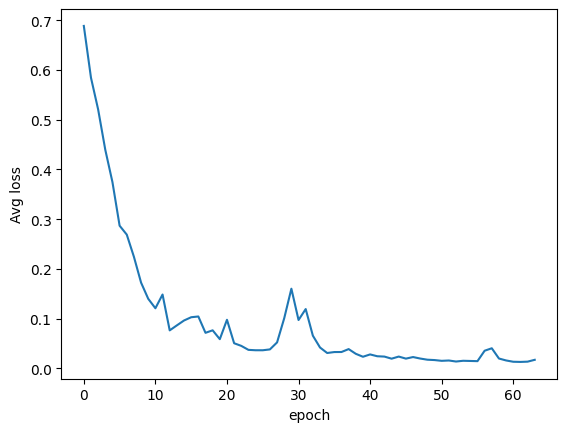

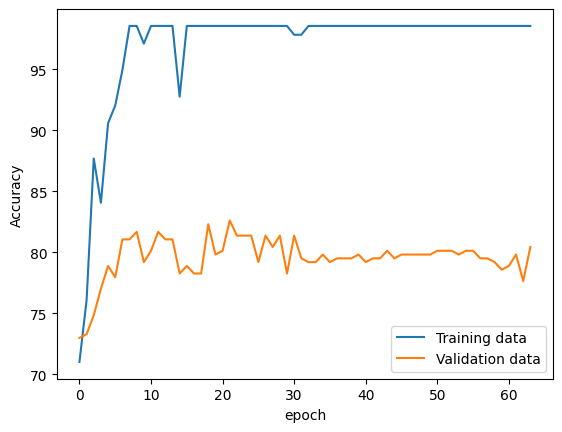

In [7]:
plt.figure()
plt.plot(results['epoch_loss'])
plt.xlabel('epoch')
plt.ylabel('Avg loss')
plt.show()


plt.figure()
plt.plot(results['training_acc'],label='Training data')
plt.plot(results['validation_acc'],label='Validation data')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.show()

### 7. Evaluate model

In [8]:
best_model_state=torch.load(bert_finetune_modelfullpath, map_location=device)
classification_model.load_state_dict(best_model_state,strict=True)
classification_model.eval()
print('Fine tune model loaded')

tr_accuracy, tr_est,tr_labels,tr_scores= evaluate_binary_accuracy(classification_model, train_loader,device)
print(f'Train Binary Accuracy: {tr_accuracy:.4f}')
perf_metrics(tr_labels, tr_est,tr_scores)
print('\n')
v_accuracy,val_est,val_labels, val_scores = evaluate_binary_accuracy(classification_model, val_loader,device)
print(f'Validation Binary Accuracy: {v_accuracy:.4f}')
perf_metrics(val_labels, val_est,val_scores)
print('\n')
test_accuracy,test_est,test_labels, test_scores = evaluate_binary_accuracy(classification_model, test_loader,device)
print(f'Test Binary Accuracy: {test_accuracy:.4f}')
perf_metrics(test_labels, test_est,test_scores)

print('Completed')

Fine tune model loaded
Train Binary Accuracy: 98.5507
Confusion Matrix:
[[72  0]
 [ 2 64]]
Accuracy: 98.55072463768117
Precision: 100.0
Sensitivity (Recall): 96.96969696969697
Specificity: 100.0
F1 Score: 0.9846153846153847
AUC Score: 0.9995791245791246


Validation Binary Accuracy: 82.6087
Confusion Matrix:
[[150  18]
 [ 38 116]]
Accuracy: 82.6086956521739
Precision: 86.56716417910447
Sensitivity (Recall): 75.32467532467533
Specificity: 89.28571428571429
F1 Score: 0.8055555555555556
AUC Score: 0.8945578231292517


Test Binary Accuracy: 76.0870
Confusion Matrix:
[[42  6]
 [16 28]]
Accuracy: 76.08695652173914
Precision: 82.35294117647058
Sensitivity (Recall): 63.63636363636363
Specificity: 87.5
F1 Score: 0.717948717948718
AUC Score: 0.787878787878788
Completed


### 8. Optimize Training Parameters via Baysian Opt

In [28]:
%%capture

from skopt import gp_minimize
from skopt.space import Real, Categorical
from skopt.utils import use_named_args


num_epochs = 64
random_seed=42
patience=80

# Define the hyperparameter space
space  = [Real(1e-7, 1e-3, "log-uniform", name='learning_rate'),
          Categorical([1,2,4, 6, 8, 10,12,14,16], name='batch_size')]

# Define the objective function
@use_named_args(space)
def objective(**params):
    learning_rate = params['learning_rate']
    batch_size = int(params['batch_size'])

    print(f'lr={learning_rate}, batch={batch_size}')

    # Prepare DataLoader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Initialize the model, criterion, and optimizer
    model = BertForMaskedLM.from_pretrained(bert_modelpath)
    classification_model = BertForSequenceClassification(model, num_classes,device)
    classification_model.to(device)  # Move model to the device (e.g., GPU if available)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(classification_model.parameters(), lr=learning_rate)


    training_arg={
    'modelfullpath': bert_finetune_modelfullpath,
    'criterion': criterion,
    'optimizer': optimizer,
    'epochs': num_epochs,
    'patience': patience,
    'seed': random_seed
    }
    
    # Training loop
    results= model_trainer(classification_model,train_loader,val_loader,training_arg,device)

    # loss is the error rate
    running_loss=1-results['best_validation_acc']/100

    # Return the final validation loss
    return running_loss

# Run Bayesian Optimization
res = gp_minimize(objective, space, n_calls=60, random_state=0)

Results

In [29]:
print(f"Best parameters: {res.x}")
print(f"Best validation loss: {res.fun}")

Best parameters: [1.888861270702437e-05, 4]
Best validation loss: 0.15838509316770188
